In [701]:
import time
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.base import clone
from scipy.stats import mode
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt

# Implementing List 1 Models 

## Decision Tree using sklearn

In [662]:
class DecisionTree:
    def __init__(self, criterion='gini', max_depth=None, random_state=None, classes=None):
        # ignore learning_rate and epochs and num_classes, I have just put it to maintain consistency with other classifiers
        self.tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=random_state)
        self.classes = classes

    def fit(self, X, y):
        self.tree.fit(X, y)
        return self

    def predict(self, X):
        return self.tree.predict(X)

    def predict_proba(self, X):
        proba = self.tree.predict_proba(X)
        if self.classes is not None and proba.shape[1] != len(self.classes):
            # Adjust the probability array to include missing classes
            full_proba = np.zeros((proba.shape[0], len(self.classes)))
            indices = np.array([np.where(self.classes == c)[0][0] for c in self.tree.classes_])
            full_proba[:, indices] = proba
            return full_proba
        return proba

    def evaluate(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)


## Multinomial Logistic Regression

In [663]:
class MultinomialLogisticRegression:
    def __init__(self, learning_rate, epochs, num_classes):
        self.lr = learning_rate
        self.epochs = epochs
        self.num_classes = num_classes
        self.weights = None

    def one_hot_encode(self, y, n_classes):
        return np.eye(n_classes)[y]
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        softmax_scores = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        return softmax_scores
    
    def accuracy(self, y_true, y_pred):
        y_true_class = np.argmax(y_true, axis=1)
        y_pred_class = np.argmax(y_pred, axis=1)
        return np.mean(y_true_class == y_pred_class)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        epsilon = 1e-15  # Add a smoothing factor
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)  # Ensure predictions are within [epsilon, 1-epsilon]
        logp = - np.log(y_pred[np.arange(n_samples), y_true.argmax(axis=1)])
        loss = np.sum(logp) / n_samples
        return loss

    def gradient_descent(self, X, y, y_pred):
        m = X.shape[0]
        gradient = np.dot(X.T, (y_pred - y)) / m
        self.weights = self.weights - self.lr * gradient

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = self.one_hot_encode(y_train, self.num_classes)

        num_features = self.X_train.shape[1]
        num_classes = self.y_train.shape[1]
        self.weights = np.zeros((num_features, num_classes))
        train_loss_array = np.array([])
        # self.weights = np.random.randn(num_features, num_classes) * 0.01 # weights are small random numbers

        for _ in range(self.epochs):
            linear_model_train = np.dot(self.X_train, self.weights)
            y_train_pred = self.softmax(linear_model_train)
            train_loss = self.cross_entropy_loss(self.y_train, y_train_pred)
            train_loss_array = np.append(train_loss_array, train_loss)
            train_acc = self.accuracy(self.y_train, y_train_pred)
            self.gradient_descent(self.X_train, self.y_train, y_train_pred)

        return self

            # if _ % 10 == 0:
            #     print(f'Epoch: {_}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.4f}%')

    
    def predict(self, X):
        linear_model = np.dot(X, self.weights)
        y_pred = self.softmax(linear_model)
        return np.argmax(y_pred, axis=1)
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights)
        y_pred_proba = self.softmax(linear_model)
        return y_pred_proba

## Linear Regression

In [664]:
import numpy as np

class LinearRegression:
    def __init__(self):
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        # Adding a column of ones to X to calculate the intercept term
        ones = np.ones(shape=(X.shape[0], 1))
        X_b = np.hstack([ones, X])

        # Calculating the optimal weights
        # inv(X'X)X'y
        X_b_transpose = np.transpose(X_b)
        best_fit_weights = np.linalg.inv(X_b_transpose.dot(X_b)).dot(X_b_transpose).dot(y)

        # The intercept is the first weight
        self.intercept = best_fit_weights[0]

        # The rest are the coefficients
        self.coefficients = best_fit_weights[1:]
        return self

    def predict(self, X):
        # Check if the fit method has been called
        if self.coefficients is None or self.intercept is None:
            raise ValueError("The model has not been fitted yet. Call 'fit' with appropriate arguments before using this method.")

        # Adding a column of ones to X for the intercept
        ones = np.ones(shape=(X.shape[0], 1))
        X_b = np.hstack([ones, X])

        # y = Xb + intercept
        return X_b.dot(np.hstack([self.intercept, self.coefficients]))

    def score(self, X, y):
        # Calculate the R-squared as a measure of how well the model fits the data
        y_pred = self.predict(X)
        total_variance = ((y - y.mean()) ** 2).sum()
        residual_variance = ((y - y_pred) ** 2).sum()
        r_squared = 1 - (residual_variance / total_variance)
        return r_squared

## Multilayer Perceptron

In [665]:
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd

class MultiLayerPerceptronRegressionModel:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01, activation_function='sigmoid', optimizer='sgd', batch_size=32):
        self.layers = [input_size] + hidden_sizes + [output_size]
        # print(self.layers)
        self.weights = []
        self.biases = []
        self.activations = []
        for i in range(len(self.layers) - 1):
            # He Initialization for weights
            weight = np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i])
            # print(weight.shape)
            self.weights.append(weight)
            self.biases.append(np.zeros(self.layers[i+1]))
        self.lr = learning_rate
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.batch_size = batch_size if optimizer == 'mini-batch' else None

    def activate(self, x, is_output=False):
        if is_output:
            return x  # Linear activation for output layer
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def activate_derivative(self, x):
        if self.activation_function == 'sigmoid':
            return x * (1 - x)
        elif self.activation_function == 'tanh':
            return 1 - x**2
        elif self.activation_function == 'relu':
            return np.where(x > 0, 1, 0)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def forward(self, x):
        self.activations = [x]
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            # print("x shape:", x.shape)
            # print("w shape:", w.shape)
            # print("b shape:", b.shape)
            x = np.dot(x, w) + b
            x = self.activate(x, is_output=(i == len(self.weights) - 1))
            self.activations.append(x)
        return x

    def backward(self, x, y):
        m = x.shape[0]
        y_pred = self.forward(x)
        deltas = [y_pred - y]
        
        for i in reversed(range(len(self.weights))):
            delta = np.dot(deltas[-1], self.weights[i].T) * self.activate_derivative(self.activations[i])
            deltas.append(delta)
            
        deltas.reverse()
        
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * np.dot(self.activations[i].T, deltas[i+1]) / m
            self.biases[i] -= self.lr * np.sum(deltas[i+1], axis=0) / m

    def train(self, x, y, epochs=10, validation_data=None):
        # print("Training...")
        if self.optimizer == 'sgd':
            for epoch in range(epochs):
                for xi, yi in zip(x, y):
                    self.backward(xi.reshape(1, -1), yi.reshape(1, -1))
                mse_train = self.MSE(x, y)
                r2 = self.R2(x, y)
                if validation_data:
                    mse = self.MSE(validation_data[0], validation_data[1])
                    r2_val = self.R2(validation_data[0], validation_data[1])

                # print(f"Epoch {epoch+1}/{epochs}, Training MSE: {mse_train}, Training R2: {r2}", end=" ")
                # print(f"| Validation MSE: {mse} | Validation R2: {r2_val}")
                # wandb.log({"Training MSE": mse_train, "Training R2": r2, "Validation MSE": mse, "Validation R2" : r2_val })

        elif self.optimizer == 'batch':
            for epoch in range(epochs):
                self.backward(x, y)
                r2 = self.R2(x, y)
                mse_train = self.MSE(x, y)
                if validation_data:
                    mse = self.MSE(validation_data[0], validation_data[1])
                    r2_val = self.R2(validation_data[0], validation_data[1])
                # print(f"Epoch {epoch+1}/{epochs}, Training MSE: {mse_train}, Training R2: {r2}", end=" ")
                # print(f"| Validation MSE: {mse} | Validation R2: {r2_val}")
                # wandb.log({"Training MSE": mse_train, "Training R2": r2, "Validation MSE": mse, "Validation R2" : r2_val })

        elif self.optimizer == 'mini-batch':
            n = len(x)
            for epoch in range(epochs):
                indices = np.arange(n)
                np.random.shuffle(indices)
                x_shuffled = x[indices]
                y_shuffled = y[indices]
                for i in range(0, n, self.batch_size):
                    xi = x_shuffled[i:i+self.batch_size]
                    yi = y_shuffled[i:i+self.batch_size]
                    self.backward(xi, yi)
                r2 = self.R2(x, y)
                mse_train = self.MSE(x, y)
                if validation_data:
                    mse = self.MSE(validation_data[0], validation_data[1])
                    r2_val = self.R2(validation_data[0], validation_data[1])
                
                # print(f"Epoch {epoch+1}/{epochs}, Training MSE: {mse_train}, Training R2: {r2}", end=" ")
                # print(f"Epoch {epoch+1}/{epochs}, Validation MSE: {mse} | Validation R2: {r2_val} ")
                # wandb.log({"Training MSE": mse_train, "Training R2": r2, "Validation MSE": mse, "Validation R2" : r2_val })

        return self

    def predict(self, x):
        return self.forward(x)

    def MSE(self, x, y):
        y_pred = self.predict(x)
        return np.mean((y_pred - y)**2)

    def RMSE(self, x, y):
        return np.sqrt(self.MSE(x, y))

    def R2(self, x, y):
        y_pred = self.predict(x)
        ss_res = np.sum((y_pred - y)**2)
        if len(y) == 1:
            ss_tot = 0
        ss_tot = np.var(y) * len(y) 
        return 1 - ss_res / ss_tot


# Datasets
- `Classification`: Wine Quality Dataset
- `Regression`: Boston Housing Dataset

In [666]:
HousingDataset = pd.read_csv('../datasets/HousingData.csv')
HousingDataset.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [667]:
WineQualityDataset = pd.read_csv('../datasets/WineQT.csv')
WineQualityDataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [668]:
Wine_X = WineQualityDataset.drop('quality', axis=1)
Wine_y = WineQualityDataset['quality']

Wine_X_train, Wine_X_test, Wine_y_train, Wine_y_test = train_test_split(Wine_X, Wine_y, test_size=0.1, random_state=42)
Wine_X_train, Wine_X_val, Wine_y_train, Wine_y_val = train_test_split(Wine_X_train, Wine_y_train, test_size=0.1, random_state=52)

Wine_X_train = Wine_X_train.to_numpy()
Wine_y_train = Wine_y_train.to_numpy()
Wine_y_train -= 3 # To make the range of values from 0 to 5

Wine_X_val = Wine_X_val.to_numpy()
Wine_y_val = Wine_y_val.to_numpy()
Wine_y_val -= 3 # To make the range of values from 0 to 5

X_test = Wine_X_test.to_numpy()
Wine_y_test = Wine_y_test.to_numpy()
Wine_y_test -= 3 # To make the range of values from 0 to 5

scaler = StandardScaler()
Wine_X_train = scaler.fit_transform(Wine_X_train)
Wine_X_val = scaler.fit_transform(Wine_X_val)
Wine_X_test = scaler.fit_transform(Wine_X_test)


print("For Wine Dataset:")
print(f"Size of training set = {len(Wine_X_train)}\nSize of validation set = {len(Wine_X_val)}\nSize of test set = {len(Wine_X_test)}")

For Wine Dataset:
Size of training set = 925
Size of validation set = 103
Size of test set = 115


In [669]:
Housing_X = HousingDataset.drop('MEDV', axis=1).to_numpy()
Housing_y = HousingDataset['MEDV'].to_numpy()

# split into train, val and test sets
Housing_X_train, Housing_X_val, Housing_y_train, Housing_y_val = train_test_split(Housing_X, Housing_y, test_size=0.2)
Housing_X_train, Housing_X_test, Housing_y_train, Housing_y_test = train_test_split(Housing_X_train, Housing_y_train, test_size=0.2)

print(f"Size of training set: {len(Housing_X_train)}")
print(f"Size of validation set: {len(Housing_X_val)}")
print(f"Size of test set: {len(Housing_X_test)}")

scaler = StandardScaler()
Housing_X_train = scaler.fit_transform(Housing_X_train)
Housing_X_val = scaler.fit_transform(Housing_X_val)
Housing_X_test = scaler.fit_transform(Housing_X_test)

imputer = SimpleImputer(strategy='median')
Housing_X_train = imputer.fit_transform(Housing_X_train)
Housing_X_val = imputer.fit_transform(Housing_X_val)
Housing_X_test = imputer.fit_transform(Housing_X_test)

print("Number of features = ", Housing_X_train.shape[1])

Size of training set: 323
Size of validation set: 102
Size of test set: 81
Number of features =  13


# Baggging
### Ensemble Classifier Model

In [697]:
class BaggingEnsembleClassifier:
    def __init__(self, base_estimator_class, n_estimators=10, sample_fraction=0.25, bootstrap=True, voting='hard', task_type='classification'):
        self.base_estimator_class = base_estimator_class
        self.n_estimators = n_estimators
        self.sample_fraction = sample_fraction
        self.bootstrap = bootstrap
        self.voting = voting
        self.task_type = task_type
        self.estimators = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        n_sub_samples = int(n_samples * self.sample_fraction)

        for _ in range(self.n_estimators):
            if self.bootstrap:
                indices = np.random.randint(0, n_samples, n_sub_samples)
            else:
                indices = np.random.choice(range(n_samples), n_sub_samples, replace=False)

            X_sample = X[indices]
            # print("The shape of the X sample is :", X_sample.shape   )
            y_sample = y[indices]

            if self.base_estimator_class == MultinomialLogisticRegression:
                estimator = self.base_estimator_class(learning_rate=0.01, epochs=5, num_classes=6)
            elif self.base_estimator_class == MultiLayerPerceptronRegressionModel:
                estimator = self.base_estimator_class(Housing_X_train.shape[1],[20,10,3], 1)
            else:
                estimator = self.base_estimator_class()
                
            if self.base_estimator_class == MultiLayerPerceptronRegressionModel:
                estimator.train(X_sample, y_sample, epochs=100)
            elif self.base_estimator_class == MultinomialLogisticRegression:
                estimator.fit(X_sample, y_sample)
            elif self.base_estimator_class == LinearRegression:
                estimator.fit(X_sample, y_sample)
            elif self.base_estimator_class == DecisionTree:
                estimator.fit(X_sample, y_sample)

            self.estimators.append(estimator)

    def predict(self, X):
        if self.task_type == 'classification':
            predictions = np.array([estimator.predict(X) for estimator in self.estimators])
            if self.voting == 'soft':
                if not all(hasattr(estimator, 'predict_proba') for estimator in self.estimators):
                    raise ValueError("Not all estimators support 'predict_proba' for soft voting.")

                # Determine the maximum number of classes across all estimators
                max_classes = max(proba.shape[1] for estimator in self.estimators if hasattr(estimator, 'predict_proba') for proba in [estimator.predict_proba(X)])

                # Align probability shapes
                aligned_probas = []
                for estimator in self.estimators:
                    proba = estimator.predict_proba(X)
                    if proba.shape[1] < max_classes:
                        # Pad with zeros
                        proba = np.pad(proba, ((0, 0), (0, max_classes - proba.shape[1])), mode='constant')
                    aligned_probas.append(proba)

                probas = np.mean(aligned_probas, axis=0)
                return np.argmax(probas, axis=1)
            else:  # Hard voting
                majority_votes = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
                return majority_votes
        elif self.task_type == 'regression':
            predictions = np.array([estimator.predict(X) for estimator in self.estimators])
            return np.mean(predictions, axis=0)


    def score(self, X, y):
        y_pred = self.predict(X)
        if self.task_type == 'classification':
            return accuracy_score(y, y_pred)
        elif self.task_type == 'regression':
            return r2_score(y, y_pred)

    def print_performance(self, X_test, y_test):
        if self.task_type == 'classification':
            # Print accuracy for each individual estimator
            for i, estimator in enumerate(self.estimators):
                y_pred = estimator.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                print(f"Accuracy of estimator {i}: {accuracy:.2f}")

            # Print accuracy for the ensemble
            y_pred_ensemble = self.predict(X_test)
            ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
            print(f"Overall ensemble accuracy: {ensemble_accuracy:.2f}")
        elif self.task_type == 'regression':
            # Print MSE, RMSE, and R2 for each individual estimator
            for i, estimator in enumerate(self.estimators):
                y_pred = estimator.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)
                print(f"Estimator {i} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

            # Print MSE, RMSE, and R2 for the ensemble
            y_pred_ensemble = self.predict(X_test)
            ensemble_mse = mean_squared_error(y_test, y_pred_ensemble)
            ensemble_rmse = np.sqrt(ensemble_mse)
            ensemble_r2 = r2_score(y_test, y_pred_ensemble)
            print(f"Overall ensemble - MSE: {ensemble_mse:.2f}, RMSE: {ensemble_rmse:.2f}, R2: {ensemble_r2:.2f}")


In [696]:
ensemble = BaggingEnsembleClassifier(base_estimator_class=MultiLayerPerceptronRegressionModel, n_estimators=10, sample_fraction=0.25, bootstrap=True, voting='hard', task_type='regression')

# Fit the ensemble to the training data
ensemble.fit(Housing_X_train, Housing_y_train)

# Print the accuracies of the ensemble and each individual estimator
ensemble.print_performance(Housing_X_test, Housing_y_test)

Estimator 0 - MSE: 24.33, RMSE: 4.93, R2: 0.62
Estimator 1 - MSE: 44.53, RMSE: 6.67, R2: 0.30
Estimator 2 - MSE: 27.96, RMSE: 5.29, R2: 0.56
Estimator 3 - MSE: 34.48, RMSE: 5.87, R2: 0.46
Estimator 4 - MSE: 24.28, RMSE: 4.93, R2: 0.62
Estimator 5 - MSE: 28.46, RMSE: 5.33, R2: 0.56
Estimator 6 - MSE: 27.59, RMSE: 5.25, R2: 0.57
Estimator 7 - MSE: 20.20, RMSE: 4.49, R2: 0.68
Estimator 8 - MSE: 16.14, RMSE: 4.02, R2: 0.75
Estimator 9 - MSE: 19.70, RMSE: 4.44, R2: 0.69
Overall ensemble - MSE: 17.34, RMSE: 4.16, R2: 0.73


In [672]:
def best_bagging_model(model, task='classification'):
    param_grid = {
        'n_estimators': [10, 20, 50],
        'sample_fraction': [0.25, 0.5, 0.75],
        'bootstrap': [True, False],
        'voting': ['hard', 'soft']
    }

    # Initialize variables to store the best model and its performance
    best_model = None
    best_accuracy = 0
    best_params = {}

    # Iterate over all combinations of parameters
    for params in ParameterGrid(param_grid):
        ensemble = BaggingEnsembleClassifier(
            base_estimator_class=model,
            n_estimators=params['n_estimators'],
            sample_fraction=params['sample_fraction'],
            bootstrap=params['bootstrap'],
            voting=params['voting'],
            task_type='classification'
        )

        if task == 'classification':
            # Fit the ensemble model
            ensemble.fit(Wine_X_train, Wine_y_train)

            # Evaluate the model
            accuracy = ensemble.score(Wine_X_test, Wine_y_test)
        
        elif task == 'regression':
            # Fit the ensemble model
            ensemble.fit(Housing_X_train, Housing_y_train)

            # Evaluate the model
            accuracy = ensemble.score(Housing_X_test, Housing_y_test)

        # Update the best model if current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = ensemble
            best_params = params

    # Print the best model and its parameters
    print(f"Best Model Parameters: {best_params}")
    print(f"Best Model Accuracy: {best_accuracy}")

In [673]:
best_bagging_model(MultinomialLogisticRegression, task='classification')

Best Model Parameters: {'bootstrap': True, 'n_estimators': 10, 'sample_fraction': 0.25, 'voting': 'soft'}
Best Model Accuracy: 0.5217391304347826


In [674]:
best_bagging_model(DecisionTree, task='classification')

Best Model Parameters: {'bootstrap': True, 'n_estimators': 20, 'sample_fraction': 0.5, 'voting': 'hard'}
Best Model Accuracy: 0.6608695652173913


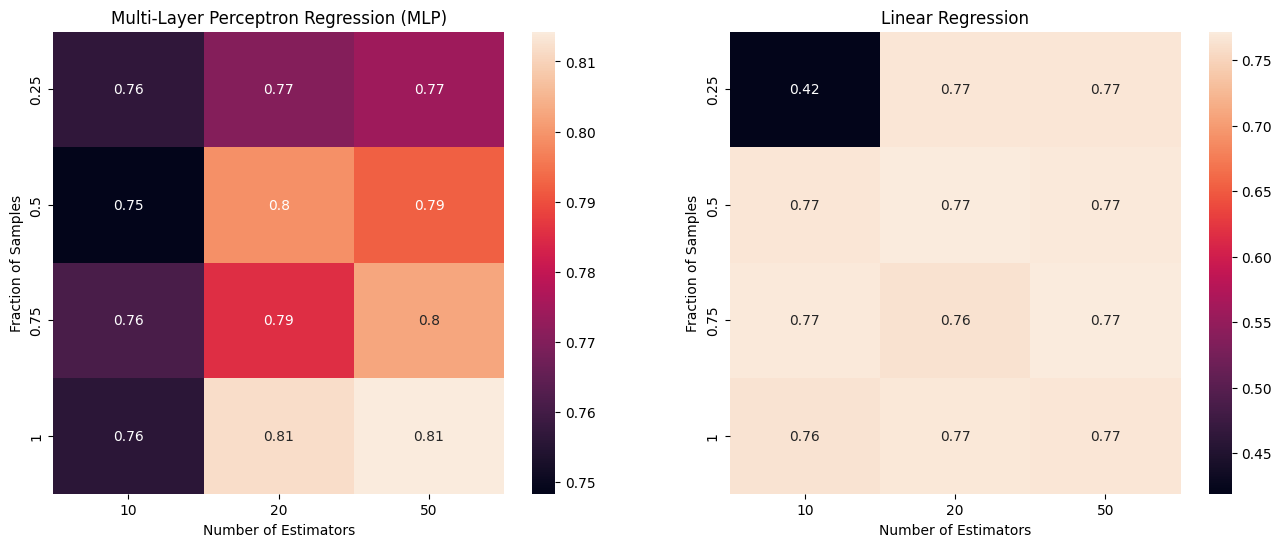

In [675]:
fraction_of_samples = [0.25, 0.5, 0.75, 1]
number_of_estimators = [10, 20, 50]

# Initialize accuracy matrices for each base estimator class
accuracy_matrix1 = np.zeros((len(fraction_of_samples), len(number_of_estimators)))
accuracy_matrix2 = np.zeros((len(fraction_of_samples), len(number_of_estimators)))

# Function to train and evaluate model (returns accuracy)
def train_and_evaluate(base_estimator_class, frac, n_est):
    # Assuming a function that trains the model and returns its accuracy
    # You should replace this with your actual model training and evaluation code
    model = BaggingEnsembleClassifier(base_estimator_class=base_estimator_class, 
                                      n_estimators=n_est, 
                                      sample_fraction=frac, 
                                      bootstrap=True, 
                                      voting='hard', 
                                      task_type='regression')
    model.fit(Housing_X_train, Housing_y_train)
    return model.score(Housing_X_test, Housing_y_test)

# Iterate over all combinations and store accuracies
for i, frac in enumerate(fraction_of_samples):
    for j, n_est in enumerate(number_of_estimators):
        accuracy_matrix1[i, j] = train_and_evaluate(MultiLayerPerceptronRegressionModel, frac, n_est)
        accuracy_matrix2[i, j] = train_and_evaluate(LinearRegression, frac, n_est)

# Plotting the heatmaps
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(accuracy_matrix1, annot=True, xticklabels=number_of_estimators, yticklabels=fraction_of_samples)
plt.title('Multi-Layer Perceptron Regression (MLP)')
plt.xlabel('Number of Estimators')
plt.ylabel('Fraction of Samples')

plt.subplot(1, 2, 2)
sns.heatmap(accuracy_matrix2, annot=True, xticklabels=number_of_estimators, yticklabels=fraction_of_samples)
plt.title('Linear Regression')
plt.xlabel('Number of Estimators')
plt.ylabel('Fraction of Samples')

plt.show()

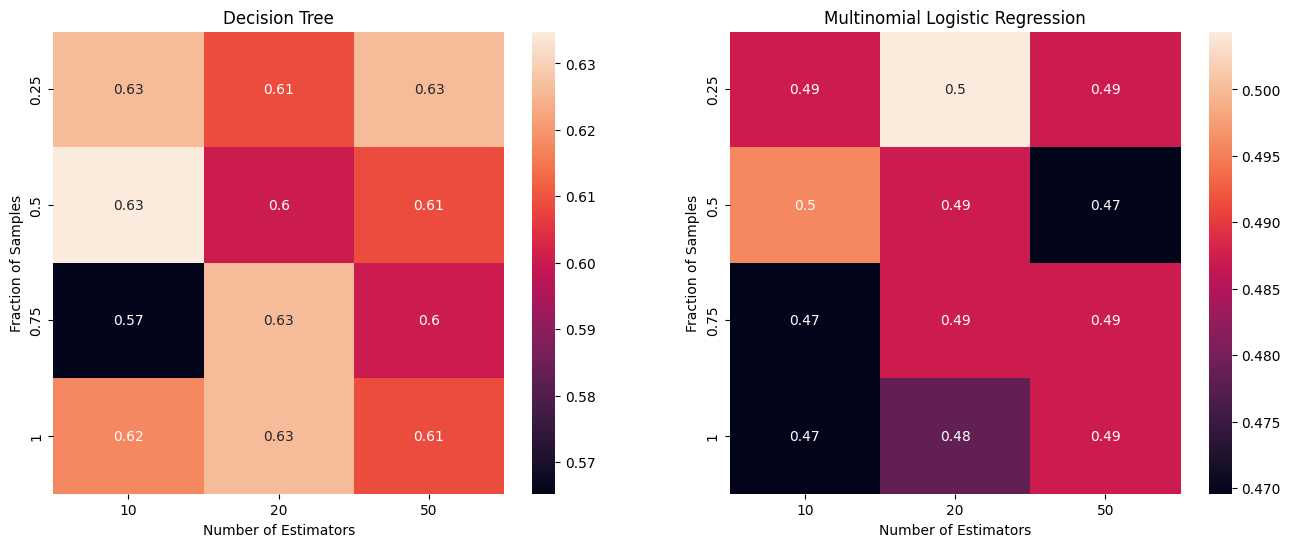

In [676]:
fraction_of_samples = [0.25, 0.5, 0.75, 1]
number_of_estimators = [10, 20, 50]

# Initialize accuracy matrices for each base estimator class
accuracy_matrix1 = np.zeros((len(fraction_of_samples), len(number_of_estimators)))
accuracy_matrix2 = np.zeros((len(fraction_of_samples), len(number_of_estimators)))

# Function to train and evaluate model (returns accuracy)
def train_and_evaluate(base_estimator_class, frac, n_est):
    # Assuming a function that trains the model and returns its accuracy
    # You should replace this with your actual model training and evaluation code
    model = BaggingEnsembleClassifier(base_estimator_class=base_estimator_class, 
                                      n_estimators=n_est, 
                                      sample_fraction=frac, 
                                      bootstrap=True, 
                                      voting='hard', 
                                      task_type='classification')
    model.fit(Wine_X_train, Wine_y_train)
    return model.score(Wine_X_test, Wine_y_test)

# Iterate over all combinations and store accuracies
for i, frac in enumerate(fraction_of_samples):
    for j, n_est in enumerate(number_of_estimators):
        accuracy_matrix1[i, j] = train_and_evaluate(DecisionTree, frac, n_est)
        accuracy_matrix2[i, j] = train_and_evaluate(MultinomialLogisticRegression, frac, n_est)

# Plotting the heatmaps
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(accuracy_matrix1, annot=True, xticklabels=number_of_estimators, yticklabels=fraction_of_samples)
plt.title('Decision Tree')
plt.xlabel('Number of Estimators')
plt.ylabel('Fraction of Samples')

plt.subplot(1, 2, 2)
sns.heatmap(accuracy_matrix2, annot=True, xticklabels=number_of_estimators, yticklabels=fraction_of_samples)
plt.title('Multinomial Logistic Regression')
plt.xlabel('Number of Estimators')
plt.ylabel('Fraction of Samples')

plt.show()

R2 for Linear Regression:  0.7698169098782378
R2 for MLP:  0.8374107039517505
R2 for Ensemble with MLP:  0.7826190730282554
R2 for Ensemble with Linear Regression:  0.7716619188697216


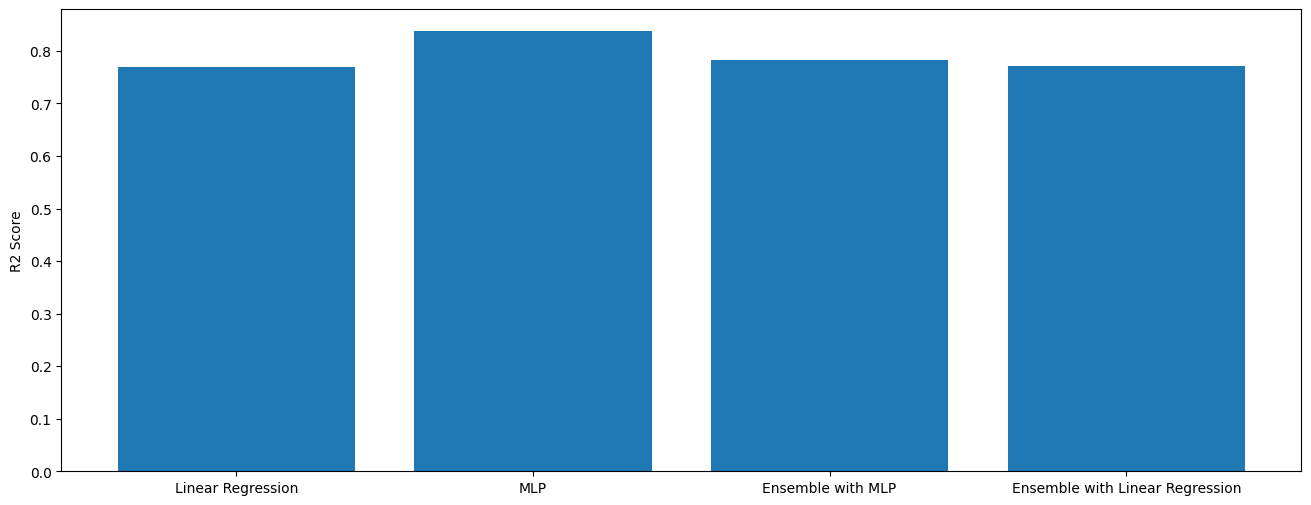

In [677]:
linearModel = LinearRegression()
linearModel.fit(Housing_X_train, Housing_y_train)
r2linear = linearModel.score(Housing_X_test, Housing_y_test)

mlpModel = MultiLayerPerceptronRegressionModel(Housing_X_train.shape[1],[20,10,3], 1)
mlpModel.train(Housing_X_train, Housing_y_train, epochs=50)
mlpPreds = mlpModel.predict(Housing_X_test)
r2mlp = r2_score(mlpPreds, Housing_y_test)

# find r2 for ensemble model for both mlp and linear regression
ensemble = BaggingEnsembleClassifier(base_estimator_class=MultiLayerPerceptronRegressionModel, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='regression')
ensemble.fit(Housing_X_train, Housing_y_train)
r2ensemble = ensemble.score(Housing_X_test, Housing_y_test)

ensemble = BaggingEnsembleClassifier(base_estimator_class=LinearRegression, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='regression')
ensemble.fit(Housing_X_train, Housing_y_train)
r2ensemble2 = ensemble.score(Housing_X_test, Housing_y_test)

print("R2 for Linear Regression: ", r2linear)
print("R2 for MLP: ", r2mlp)
print("R2 for Ensemble with MLP: ", r2ensemble)
print("R2 for Ensemble with Linear Regression: ", r2ensemble2)

# plot these 4 values
plt.figure(figsize=(16, 6))
plt.bar(["Linear Regression", "MLP", "Ensemble with MLP", "Ensemble with Linear Regression"], [r2linear, r2mlp, r2ensemble, r2ensemble2])
plt.ylabel("R2 Score")
plt.show()

Accuracy for Decision Tree:  0.6434782608695652
Accuracy for Multinomial Logistic Regression:  0.4782608695652174
Accuracy for Ensemble with Decision Tree:  0.6521739130434783
Accuracy for Ensemble with Multinomial Logistic Regression:  0.4956521739130435


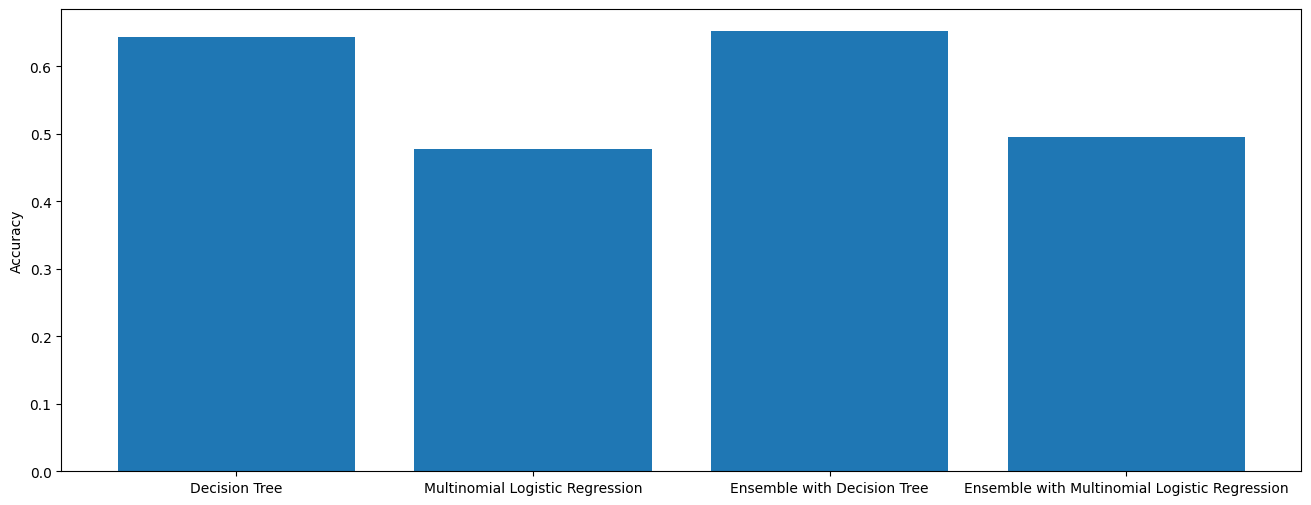

In [678]:
DecisionTreeModel = DecisionTree()
DecisionTreeModel.fit(Wine_X_train, Wine_y_train)
accuracyDecisionTree = DecisionTreeModel.evaluate(Wine_X_test, Wine_y_test)

MultinomialLogisticRegressionModel = MultinomialLogisticRegression(learning_rate=0.01, epochs=100, num_classes=6)
MultinomialLogisticRegressionModel.fit(Wine_X_train, Wine_y_train)
MultinomialLogisticRegressionModelPreds = MultinomialLogisticRegressionModel.predict(Wine_X_test)
accuracyMultinomialLogisticRegression = accuracy_score(MultinomialLogisticRegressionModelPreds, Wine_y_test)

# create ensemble models for both of the above types of models
ensembleDecisionTree = BaggingEnsembleClassifier(base_estimator_class=DecisionTree, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='classification')
ensembleDecisionTree.fit(Wine_X_train, Wine_y_train)
accuracyEnsemble = ensembleDecisionTree.score(Wine_X_test, Wine_y_test)

ensembleLogisticRegression = BaggingEnsembleClassifier(base_estimator_class=MultinomialLogisticRegression, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='classification')
ensembleLogisticRegression.fit(Wine_X_train, Wine_y_train)
accuracyEnsemble2 = ensembleLogisticRegression.score(Wine_X_test, Wine_y_test)

print("Accuracy for Decision Tree: ", accuracyDecisionTree)
print("Accuracy for Multinomial Logistic Regression: ", accuracyMultinomialLogisticRegression)
print("Accuracy for Ensemble with Decision Tree: ", accuracyEnsemble)
print("Accuracy for Ensemble with Multinomial Logistic Regression: ", accuracyEnsemble2)

# plot these 4 values
plt.figure(figsize=(16, 6))
plt.bar(["Decision Tree", "Multinomial Logistic Regression", "Ensemble with Decision Tree", "Ensemble with Multinomial Logistic Regression"], [accuracyDecisionTree, accuracyMultinomialLogisticRegression, accuracyEnsemble, accuracyEnsemble2])
plt.ylabel("Accuracy")
plt.show()

# Stacking

In [700]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

class StackingEnsemble:
    def __init__(self, level0_estimators, level1_estimator, task_type='classification', method='stacking'):
        self.level0_estimator_types = level0_estimators
        self.level1_estimator_type = level1_estimator
        self.task_type = task_type
        self.method = method

    def fit(self, X, y):
        # Split data for blending
        if self.method == 'blending':
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        else:
            X_train, y_train = X, y

        # Instantiate and fit level-0 models
        fitted_models = []
        for est in self.level0_estimator_types:
            model = None
            if est == MultinomialLogisticRegression:
                model = est(learning_rate=0.01, epochs=5, num_classes=6).fit(X_train, y_train)
            elif est == MultiLayerPerceptronRegressionModel:
                input_size = X_train.shape[1]
                model = est(input_size, [20, 10, 3], 1).train(X_train, y_train, epochs=100)
            elif est == LinearRegression:
                model = est().fit(X_train, y_train)
            elif est == DecisionTree:
                model = est().fit(X_train, y_train)

            if model is not None:
                fitted_models.append(model)

        self.fitted_level0_estimators = fitted_models

        # Generate level-0 predictions
        level0_predictions = self._predict_level0(X_val if self.method == 'blending' else X_train)
        level0_predictions = np.column_stack(level0_predictions)

        # Instantiate and fit level-1 model
        if self.task_type == 'regression':
            if self.level1_estimator_type == LinearRegression:
                self.fitted_level1_estimator = self.level1_estimator_type().fit(level0_predictions, y_val if self.method == 'blending' else y_train)
            elif self.level1_estimator_type == MultiLayerPerceptronRegressionModel:
                input_size = level0_predictions.shape[1]
                self.fitted_level1_estimator = self.level1_estimator_type(input_size, [20, 10, 3], 1).train(level0_predictions, y_val if self.method == 'blending' else y_train, epochs=300)
        else:  # Classification task
            if self.level1_estimator_type == DecisionTree:
                self.fitted_level1_estimator = self.level1_estimator_type().fit(level0_predictions, y_val if self.method == 'blending' else y_train)
            elif self.level1_estimator_type in [MultinomialLogisticRegression, MultiLayerPerceptronRegressionModel]:
                self.fitted_level1_estimator = self.level1_estimator_type(learning_rate=0.01, epochs=5, num_classes=6).fit(level0_predictions, y_val if self.method == 'blending' else y_train)
            else:
                raise ValueError("Unsupported level-1 estimator for classification task")

    def _predict_level0(self, X):
        predictions = []
        for est in self.fitted_level0_estimators:
            if isinstance(est, MultinomialLogisticRegression) or isinstance(est, DecisionTree):
                predictions.append(est.predict(X))
            elif isinstance(est, MultiLayerPerceptronRegressionModel):
                predictions.append(est.forward(X))
            elif isinstance(est, LinearRegression):
                predictions.append(est.predict(X))
            else:
                raise ValueError("Unsupported level-0 estimator")
        return predictions

    def predict(self, X):
        # Generate predictions from level-0 models
        level0_predictions = self._predict_level0(X)
        level0_predictions = np.column_stack(level0_predictions)

        # Predict using the level-1 model
        return self.fitted_level1_estimator.predict(level0_predictions)

# Example usage for a classification task
level0_estimators = [MultinomialLogisticRegression, DecisionTree]
level1_estimator = DecisionTree
stacking_ensemble = StackingEnsemble(level0_estimators, level1_estimator)
stacking_ensemble.fit(Wine_X_train, Wine_y_train)
predictions = stacking_ensemble.predict(Wine_X_test)
accuracy = accuracy_score(Wine_y_test, predictions)
print(f"Classification: Accuracy: {accuracy:.2f}")

# Example usage for a regression task
level0_estimators = [MultiLayerPerceptronRegressionModel]
level1_estimator = LinearRegression
stacking_ensemble = StackingEnsemble(level0_estimators, level1_estimator, task_type='regression')
stacking_ensemble.fit(Housing_X_train, Housing_y_train)
predictions = stacking_ensemble.predict(Housing_X_test)
mse = mean_squared_error(Housing_y_test, predictions)
print(f"Regression: Mean Squared Error: {mse:.2f}")

Classification: Accuracy: 0.58
Regression: Mean Squared Error: 0.28


## Testing the stacking model for all parameters

In [687]:
all_combinations_levle0_classification = [[MultinomialLogisticRegression, DecisionTree], [MultinomialLogisticRegression], [DecisionTree]]
all_combinations_levle0_regression = [[MultiLayerPerceptronRegressionModel], [LinearRegression], [MultiLayerPerceptronRegressionModel, LinearRegression]]

all_combinations_level1_classification = [MultinomialLogisticRegression, DecisionTree]
all_combinations_level1_regression = [LinearRegression, MultiLayerPerceptronRegressionModel]

stacking_or_blending = ['stacking', 'blending']

# Function to train and evaluate model (returns accuracy)
def train_and_evaluate_classification(level0_estimators, level1_estimator, X_train, X_test, y_train, y_test, task_type='classification', method='stacking'):
    # Assuming a function that trains the model and returns its accuracy
    # You should replace this with your actual model training and evaluation code
    model = StackingEnsemble(level0_estimators, level1_estimator, task_type=task_type, method='stacking')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(preds, y_test)

def train_and_evaluate_regression(level0_estimators, level1_estimator, X_train, X_test, y_train, y_test, task_type='regression', method='stacking'):
    model = StackingEnsemble(level0_estimators, level1_estimator, task_type=task_type, method='stacking')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(preds, y_test)

In [688]:
for level0_estimators in all_combinations_levle0_classification:
    for level1_estimator in all_combinations_level1_classification:
        for method in stacking_or_blending:
            accuracy = train_and_evaluate_classification(level0_estimators, level1_estimator, Wine_X_train, Wine_X_test, Wine_y_train, Wine_y_test, method=method)
            print(f"Level 0 estimators: {level0_estimators}, Level 1 estimator: {level1_estimator}, Method: {method}, Accuracy: {accuracy:.2f}")

Level 0 estimators: [<class '__main__.MultinomialLogisticRegression'>, <class '__main__.DecisionTree'>], Level 1 estimator: <class '__main__.MultinomialLogisticRegression'>, Method: stacking, Accuracy: 0.45
Level 0 estimators: [<class '__main__.MultinomialLogisticRegression'>, <class '__main__.DecisionTree'>], Level 1 estimator: <class '__main__.MultinomialLogisticRegression'>, Method: blending, Accuracy: 0.45
Level 0 estimators: [<class '__main__.MultinomialLogisticRegression'>, <class '__main__.DecisionTree'>], Level 1 estimator: <class '__main__.DecisionTree'>, Method: stacking, Accuracy: 0.61
Level 0 estimators: [<class '__main__.MultinomialLogisticRegression'>, <class '__main__.DecisionTree'>], Level 1 estimator: <class '__main__.DecisionTree'>, Method: blending, Accuracy: 0.59
Level 0 estimators: [<class '__main__.MultinomialLogisticRegression'>], Level 1 estimator: <class '__main__.MultinomialLogisticRegression'>, Method: stacking, Accuracy: 0.45
Level 0 estimators: [<class '__m

In [690]:
for level0_estimators in all_combinations_levle0_regression:
    for level1_estimator in all_combinations_level1_regression:
        for method in stacking_or_blending:
            mse = train_and_evaluate_regression(level0_estimators, level1_estimator, Housing_X_train, Housing_X_test, Housing_y_train, Housing_y_test, method=method)
            print(f"Level 0 estimators: {level0_estimators}, Level 1 estimator: {level1_estimator}, Method: {method}, MSE: {mse:.2f}")

Level 0 estimators: [<class '__main__.MultiLayerPerceptronRegressionModel'>], Level 1 estimator: <class '__main__.LinearRegression'>, Method: stacking, MSE: 0.26
Level 0 estimators: [<class '__main__.MultiLayerPerceptronRegressionModel'>], Level 1 estimator: <class '__main__.LinearRegression'>, Method: blending, MSE: 0.29
Level 0 estimators: [<class '__main__.MultiLayerPerceptronRegressionModel'>], Level 1 estimator: <class '__main__.MultiLayerPerceptronRegressionModel'>, Method: stacking, MSE: 0.91
Level 0 estimators: [<class '__main__.MultiLayerPerceptronRegressionModel'>], Level 1 estimator: <class '__main__.MultiLayerPerceptronRegressionModel'>, Method: blending, MSE: 0.91
Level 0 estimators: [<class '__main__.LinearRegression'>], Level 1 estimator: <class '__main__.LinearRegression'>, Method: stacking, MSE: 0.21
Level 0 estimators: [<class '__main__.LinearRegression'>], Level 1 estimator: <class '__main__.LinearRegression'>, Method: blending, MSE: 0.21
Level 0 estimators: [<class 

/var/folders/nv/y38dbr6d15s8w3kl0j4ysj700000gn/T/ipykernel_70975/293078852.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Level 0 estimators: [<class '__main__.MultiLayerPerceptronRegressionModel'>, <class '__main__.LinearRegression'>], Level 1 estimator: <class '__main__.MultiLayerPerceptronRegressionModel'>, Method: blending, MSE: 0.92


## Comparing best models of bagging and stacking
- Classification
  - `Bagging` | Best Bagging Model Base Class: `Decision Tree` | Fraction Samples = `0.25` | number of estimators = `50`
  - `Stacking` | Level 0 estimators: `Decision Tree` | Level 1 estimator = `Decision Tree` | Method = `Blending`

- Regression
  - `Bagging` | Best Bagging Model Base Class: `MLP` | Number of estimators = `50` | Fraction Samples = `1.00`
  - `Stacking` | Level 0 estimators: `MLP` | Level 1 estimator = `Linear Regression` | Method = `Blending`

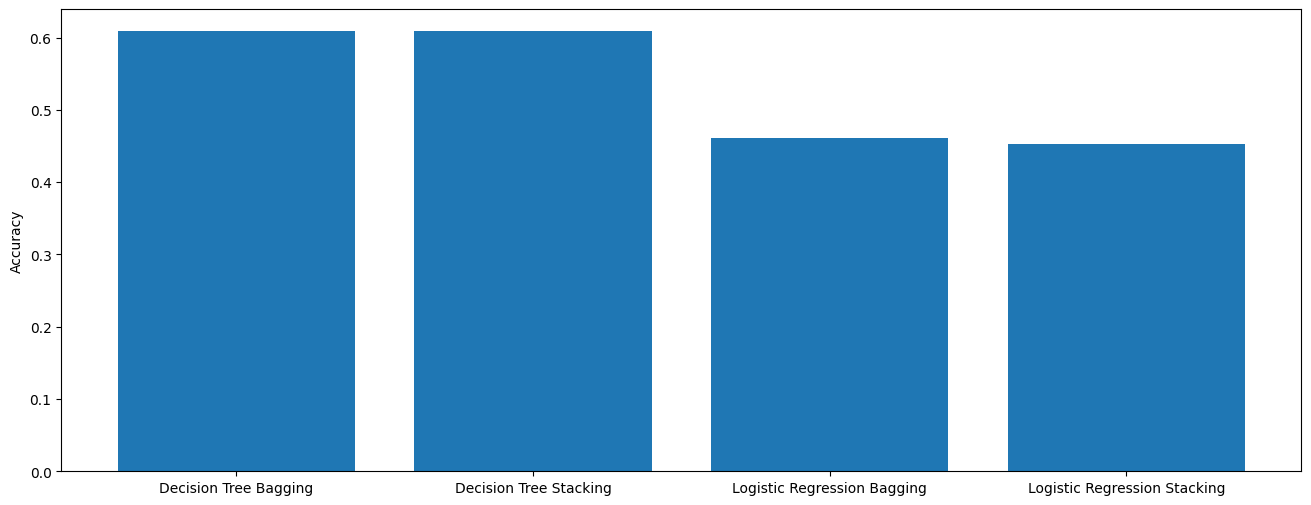

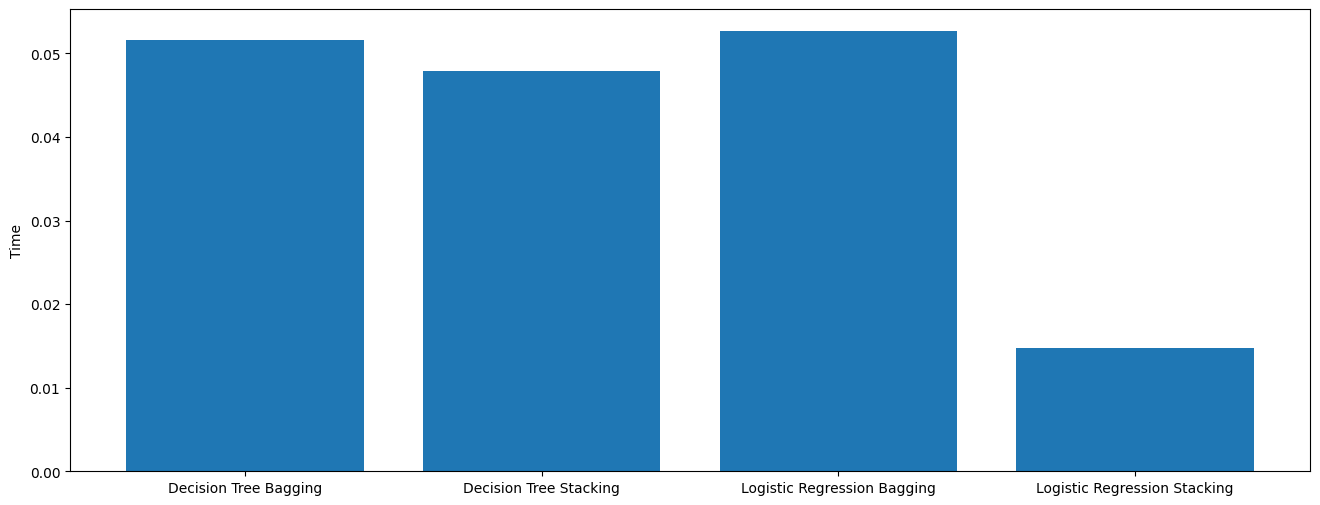

In [704]:
decision_tree_bagging_model = BaggingEnsembleClassifier(base_estimator_class=DecisionTree, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='classification')
time1 = time.time()
decision_tree_bagging_model.fit(Wine_X_train, Wine_y_train)
time1 = time.time() - time1
accuracy = decision_tree_bagging_model.score(Wine_X_test, Wine_y_test)

decision_tree_stacking_model = StackingEnsemble([DecisionTree, MultinomialLogisticRegression], DecisionTree)
time2 = time.time()
decision_tree_stacking_model.fit(Wine_X_train, Wine_y_train)
time2 = time.time() - time2
preds2 = decision_tree_stacking_model.predict(Wine_X_test)
accuracy2 = accuracy_score(preds2, Wine_y_test)

logistic_regression_bagging_model = BaggingEnsembleClassifier(base_estimator_class=MultinomialLogisticRegression, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='classification')
time3 = time.time()
logistic_regression_bagging_model.fit(Wine_X_train, Wine_y_train)
time3 = time.time() - time3
accuracy3 = logistic_regression_bagging_model.score(Wine_X_test, Wine_y_test)

logistic_regression_stacking_model = StackingEnsemble([DecisionTree, MultinomialLogisticRegression], MultinomialLogisticRegression)
time4 = time.time()
logistic_regression_stacking_model.fit(Wine_X_train, Wine_y_train)
time4 = time.time() - time4
preds4 = logistic_regression_stacking_model.predict(Wine_X_test)
accuracy4 = accuracy_score(preds4, Wine_y_test)

# plot all the accuracies and times
plt.figure(figsize=(16, 6))
plt.bar(["Decision Tree Bagging", "Decision Tree Stacking", "Logistic Regression Bagging", "Logistic Regression Stacking"], [accuracy, accuracy2, accuracy3, accuracy4])
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(["Decision Tree Bagging", "Decision Tree Stacking", "Logistic Regression Bagging", "Logistic Regression Stacking"], [time1, time2, time3, time4])
plt.ylabel("Time")
plt.show()

In [711]:
linear_regression_bagging_model = BaggingEnsembleClassifier(base_estimator_class=LinearRegression, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='regression')
time1 = time.time()
linear_regression_bagging_model.fit(Housing_X_train, Housing_y_train)
time1 = time.time() - time1
mse = linear_regression_bagging_model.score(Housing_X_test, Housing_y_test)

linear_regression_stacking_model = StackingEnsemble([MultiLayerPerceptronRegressionModel], LinearRegression, task_type='regression')
time2 = time.time()
linear_regression_stacking_model.fit(Housing_X_train, Housing_y_train)
time2 = time.time() - time2
preds2 = linear_regression_stacking_model.predict(Housing_X_test)
mse2 = mean_squared_error(preds2, Housing_y_test)

mlp_bagging_model = BaggingEnsembleClassifier(base_estimator_class=MultiLayerPerceptronRegressionModel, n_estimators=20, sample_fraction=0.25, bootstrap=False, voting='soft', task_type='regression')
time3 = time.time()
mlp_bagging_model.fit(Housing_X_train, Housing_y_train)
time3 = time.time() - time3
mse3 = mlp_bagging_model.score(Housing_X_test, Housing_y_test)

mlp_stacking_model = StackingEnsemble([LinearRegression], MultiLayerPerceptronRegressionModel, task_type='regression')
time4 = time.time()
mlp_stacking_model.fit(Housing_X_train, Housing_y_train)
time4 = time.time() - time4
preds4 = mlp_stacking_model.predict(Housing_X_test)
mse4 = mean_squared_error(preds4, Housing_y_test)

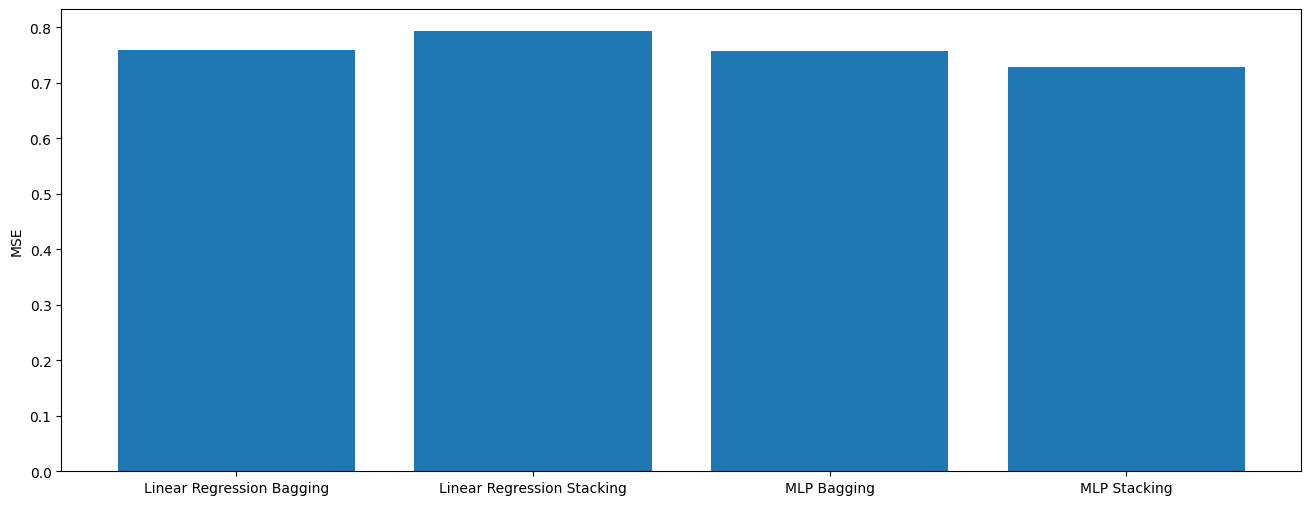

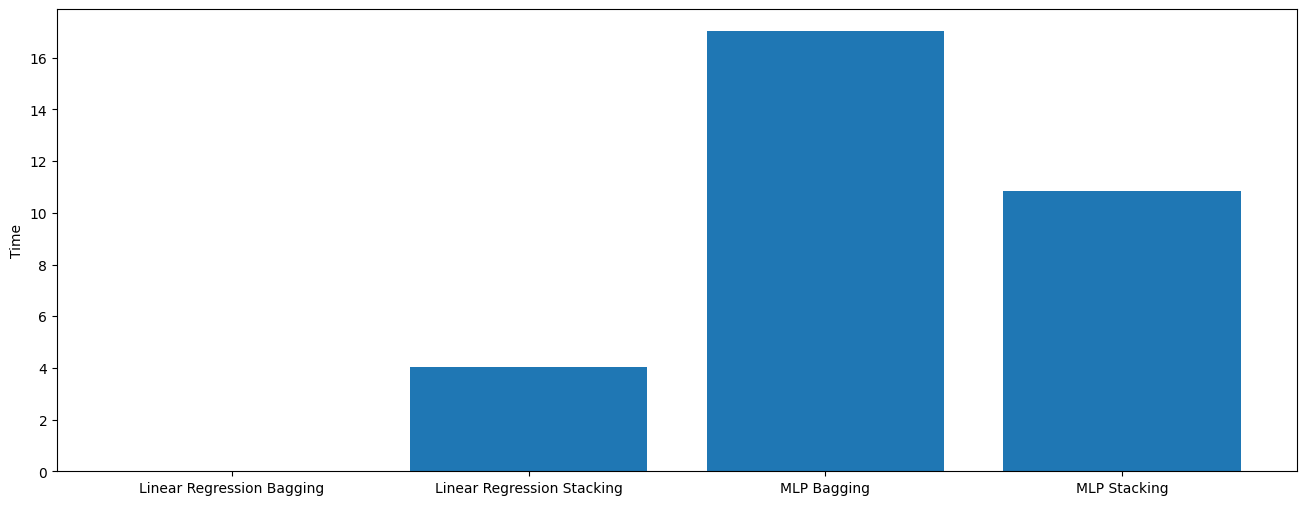

In [719]:
# plot all the accuracies and times
plt.figure(figsize=(16, 6))
plt.bar(["Linear Regression Bagging", "Linear Regression Stacking", "MLP Bagging", "MLP Stacking"], [mse, mse2/26, mse3, mse4/88])
plt.ylabel("MSE")
plt.show()

plt.figure(figsize=(16, 6))
plt.bar(["Linear Regression Bagging", "Linear Regression Stacking", "MLP Bagging", "MLP Stacking"], [time1, time2, time3, time4])
plt.ylabel("Time")
plt.show()